# Functional Programming Big Data Using Spark

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

In [2]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8MB 141kB/s eta 0:00:014    |█████████████████████▍          | 145.6MB 9.0MB/s eta 0:00:09��██████████   | 197.0MB 9.5MB/s eta 0:00:03
     |████████████████████████████████| 204kB 34.3MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')


In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

## Mean

In [5]:
rdd = sc.parallelize([101]+list(range(100)))

In [6]:
sum = rdd.sum()
n = rdd.count()
mean = sum/n
mean

50.00990099009901

## Median

In [9]:
sortedAndIndex  = rdd.sortBy(lambda x : x).zipWithIndex().map(lambda val : (val[1],val[0]))
n = sortedAndIndex.count()
if (n % 2 == 1):
    index = (n-1)/2
    print(sortedAndIndex.lookup(index))
else:
    index1 = (n/2)-1
    index2 = n/2
    value1 = sortedAndIndex.lookup(index1)[0]
    value2 = sortedAndIndex.lookup(index2)[0]
    print((value1+value2)/2)

[50]


## Standartd Deviation

In [10]:
rdd = sc.parallelize(list(range(100)))

In [11]:
sum = rdd.sum()
n = rdd.count()
mean = sum/n
mean

49.5

In [12]:
from math import sqrt
sd = sqrt(rdd.map(lambda x : pow(x-mean,2)).sum()/n)
sd

28.86607004772212

## Skewness

In [13]:
n = float(n)
skewness = n/((n-1)*(n-2))*rdd.map(lambda x : pow(x-mean,3)/pow(sd,3)).sum()
skewness

6.40821370635011e-17

## Kurtosis

In [14]:
kurtosis = rdd.map(lambda x : pow(x-mean,4)/pow(sd,4)).sum()/(1-n)
kurtosis

-1.8179393696945456

## Covariace & Correlation 

In [15]:
rddX = sc.parallelize(list(range(100)))
rddY = sc.parallelize(list(range(100)))

In [16]:
meanX = rddX.sum()/float(rddX.count())
meanY = rddY.sum()/float(rddY.count())
print(meanX)
print(meanY)

49.5
49.5


In [17]:
rddXY = rddX.zip(rddY)
covXY = rddXY.map(lambda x_y : (x_y[0] - meanX)*(x_y[1] - meanY)).sum()/rddXY.count()
covXY

833.25

In [18]:
from math import sqrt
sdX = sqrt(rddX.map(lambda x : pow(x-meanX,2)).sum()/n)
sdY = sqrt(rddY.map(lambda x : pow(x-meanY,2)).sum()/n)
print(sdX)
print(sdY)

28.86607004772212
28.86607004772212


In [19]:
corrXY = covXY/(sdX*sdY)
corrXY

1.0

## Covariance Matrix

In [20]:
import random
from pyspark.mllib.stat import Statistics

column1 = sc.parallelize(range(100))
column2 = sc.parallelize(range(100,200))
column3 = sc.parallelize(range(99, -1, -1))
column4 = sc.parallelize(random.sample(range(100),100))
column1 = column1.repartition(1)
column2 = column2.repartition(1)
column3 = column3.repartition(1)
column4 = column4.repartition(1)

data = column1.zip(column2).zip(column3).zip(column4)
# print(data.take(5))
data = data.map(lambda row : [row[0][0][0], row[0][0][1], row[0][1], row[1]])
# print(data.take(5))
Statistics.corr(data)


array([[ 1.        ,  1.        , -1.        , -0.08936094],
       [ 1.        ,  1.        , -1.        , -0.08936094],
       [-1.        , -1.        ,  1.        ,  0.08936094],
       [-0.08936094, -0.08936094,  0.08936094,  1.        ]])

## Real Data

In [21]:
# delete files from previous runs
!rm -f hmp.parquet*

# download the file containing the data in PARQUET format
!wget https://github.com/IBM/coursera/raw/master/hmp.parquet
    
# create a dataframe out of it
df = spark.read.parquet('hmp.parquet')

# register a corresponding query table
df.createOrReplaceTempView('df')

--2020-05-05 16:47:13--  https://github.com/IBM/coursera/raw/master/hmp.parquet
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet [following]
--2020-05-05 16:47:13--  https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet [following]
--2020-05-05 16:47:13--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932997 (911K) [application/octet-stream]
Savin

In [22]:
df.show()
df.printSchema()

+---+---+---+--------------------+-----------+
|  x|  y|  z|              source|      class|
+---+---+---+--------------------+-----------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 34|Accelerometer-201...|Brush_teeth|
| 20| 50| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 50| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 35|Accelerometer-201...|Brush_teeth|
| 21| 51| 33|Accelerometer-201...|Brush_teeth|
| 20| 50| 34|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 20| 51| 35|Accelerometer-201...|Brush_teeth|
| 18| 49| 34|Accelerometer-201...|Brush_teeth|
| 19| 48| 34|Accelerometer-201...|Brush_teeth|
| 16| 53| 34|Accelerometer-201...|Brush_teeth|
| 18| 52| 35|

In [23]:
spark.sql('select class,count(*) from df group by class').show()

+--------------+--------+
|         class|count(1)|
+--------------+--------+
| Use_telephone|   15225|
| Standup_chair|   25417|
|      Eat_meat|   31236|
|     Getup_bed|   45801|
|   Drink_glass|   42792|
|    Pour_water|   41673|
|     Comb_hair|   23504|
|          Walk|   92254|
|  Climb_stairs|   40258|
| Sitdown_chair|   25036|
|   Liedown_bed|   11446|
|Descend_stairs|   15375|
|   Brush_teeth|   29829|
|      Eat_soup|    6683|
+--------------+--------+



In [24]:
df.groupBy('class').count().show()

+--------------+-----+
|         class|count|
+--------------+-----+
| Use_telephone|15225|
| Standup_chair|25417|
|      Eat_meat|31236|
|     Getup_bed|45801|
|   Drink_glass|42792|
|    Pour_water|41673|
|     Comb_hair|23504|
|          Walk|92254|
|  Climb_stairs|40258|
| Sitdown_chair|25036|
|   Liedown_bed|11446|
|Descend_stairs|15375|
|   Brush_teeth|29829|
|      Eat_soup| 6683|
+--------------+-----+



In [31]:
!pip install --user --upgrade pixiedust

     |████████████████████████████████| 204kB 19.9MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/e8/b1/86/c2f2e16e6bf9bfe556f9dbf8adb9f41816c476d73078c7d0eb
Successfully built pixiedust
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [32]:
import pixiedust
from pyspark.sql.functions import col
counts = df.groupBy('class').count().orderBy('count')
display(counts)

DataFrame[class: string, count: bigint]

In [33]:
spark.sql('''
    select 
        *,
        max/min as minmaxratio -- compute minmaxratio based on previously computed values
        from (
            select 
                min(ct) as min, -- compute minimum value of all classes
                max(ct) as max, -- compute maximum value of all classes
                mean(ct) as mean, -- compute mean between all classes
                stddev(ct) as stddev -- compute standard deviation between all classes
                from (
                    select
                        count(*) as ct -- count the number of rows per class and rename it to ct
                        from df -- access the temporary query table called df backed by DataFrame df
                        group by class -- aggrecate over class
                )
        )   
''').show()

+----+-----+------------------+------------------+-----------------+
| min|  max|              mean|            stddev|      minmaxratio|
+----+-----+------------------+------------------+-----------------+
|6683|92254|31894.928571428572|21284.893716741157|13.80427951518779|
+----+-----+------------------+------------------+-----------------+



In [27]:
from pyspark.sql.functions import col, min, max, mean, stddev

df \
    .groupBy('class') \
    .count() \
    .select([ 
        min(col("count")).alias('min'), 
        max(col("count")).alias('max'), 
        mean(col("count")).alias('mean'), 
        stddev(col("count")).alias('stddev') 
    ]) \
    .select([
        col('*'),
        (col("max") / col("min")).alias('minmaxratio')
    ]) \
    .show()

+----+-----+------------------+------------------+-----------------+
| min|  max|              mean|            stddev|      minmaxratio|
+----+-----+------------------+------------------+-----------------+
|6683|92254|31894.928571428572|21284.893716741157|13.80427951518779|
+----+-----+------------------+------------------+-----------------+



In [28]:
counts = df.groupBy('class').count().orderBy('count', ascending=[0, 1]).show()


+--------------+-----+
|         class|count|
+--------------+-----+
|          Walk|92254|
|     Getup_bed|45801|
|   Drink_glass|42792|
|    Pour_water|41673|
|  Climb_stairs|40258|
|      Eat_meat|31236|
|   Brush_teeth|29829|
| Standup_chair|25417|
| Sitdown_chair|25036|
|     Comb_hair|23504|
|Descend_stairs|15375|
| Use_telephone|15225|
|   Liedown_bed|11446|
|      Eat_soup| 6683|
+--------------+-----+



In [29]:
counts

## Ploting

In [35]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-05-05 16:58:12--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-05-05 16:58:12--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-05-05 16:58:12--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [36]:
df = spark.read.parquet('washing.parquet')

In [37]:
df.count()

2058

In [38]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [43]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[222, 220, 235, 231, 230, 222, 238, 227, 228, 229, 239, 221, 235, 226, 238]

In [44]:
%matplotlib inline

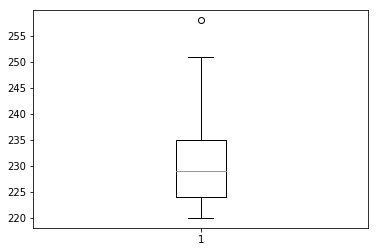

In [45]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

In [46]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808767938, 1547808782951, 1547808809967, 1547808870039, 1547808876043, 1547808915092, 1547808933120, 1547808954133, 1547808984163, 1547809011179, 1547809026203, 1547809041212, 1547809065223, 1547809086239, 1547809194321]
[224, 220, 229, 231, 221, 238, 228, 236, 229, 242, 221, 235, 222, 222, 239]


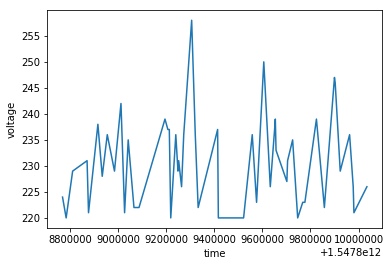

In [47]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [48]:
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



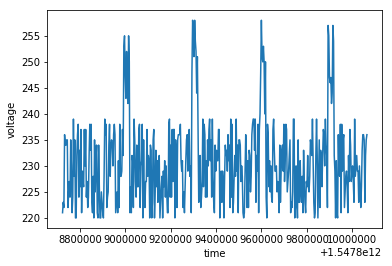

In [50]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [51]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

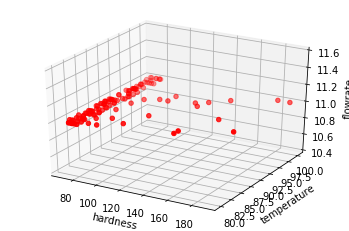

In [52]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

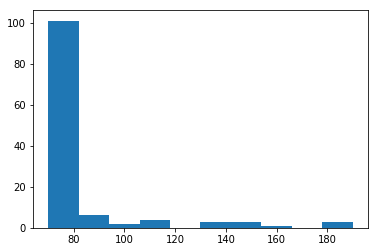

In [53]:
plt.hist(result_array_hardness)
plt.show()

# PCA

In [54]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

In [55]:
df.count()-result.count()

7

In [56]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [57]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")

In [58]:
features = assembler.transform(result)

In [59]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

In [60]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

In [61]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

In [62]:
result_pca.count()

2051

In [63]:
rdd = result_pca.rdd.sample(False,0.8)

In [64]:
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()

In [65]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

In [66]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

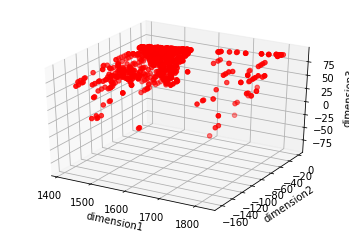

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

In [70]:
pca

PCA_49abd299b826